# Olive Oil Export - Model Training

This notebook trains two models:
1. **Random Forest Regressor** - for predicting export quantities
2. **Prophet** - for time series forecasting (France exports)

Both models are saved to the `models/` folder for future use.

## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from prophet import Prophet
import matplotlib.pyplot as plt
import joblib
import os

# Load data
df = pd.read_csv('../data/raw/tunisia_olive_oil_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Ensure these exist (derive from Date for clarity)
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

print(f"Data: {len(df):,} rows, {df['Country'].nunique()} countries | {df['Date'].min().date()} → {df['Date'].max().date()}")

c:\Learn Programming\MachineLearning\olive-oil-forecasting\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


Data: 7,560 rows, 42 countries | 2010-01-15 → 2024-09-28


## 2. Train Random Forest Model

Predict export quantities using Year, Month, USD_Price, and Production_Tons as features.

In [2]:
# Features/target and split
X = df[['Year', 'Month', 'USD_Price', 'Production_Tons']]
y = df['Export_Tons']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train and evaluate
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RandomForest — R2: {r2:.3f}, MAE: {mae:.0f} tons")

RandomForest — R2: -0.107, MAE: 11585 tons


## 3. Train Prophet Model (France Exports)

Forecast France's olive oil exports using Facebook Prophet for time series analysis.

In [3]:
# France monthly exports for Prophet
france = df[df['Country'] == 'France'][['Date', 'Export_Tons']].rename(columns={'Date': 'ds', 'Export_Tons': 'y'})
monthly = france.resample('M', on='ds').sum().reset_index()

prophet = Prophet(yearly_seasonality=True)
prophet.fit(monthly)

C:\Users\21629\AppData\Local\Temp\ipykernel_14860\3582107135.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = france.resample('M', on='ds').sum().reset_index()
23:11:20 - cmdstanpy - INFO - Chain [1] start processing
23:11:20 - cmdstanpy - INFO - Chain [1] start processing
23:11:21 - cmdstanpy - INFO - Chain [1] done processing
23:11:21 - cmdstanpy - INFO - Chain [1] done processing


## 4. Save Models

Save both trained models to the `models/` folder for future predictions.

In [4]:
# Save models
os.makedirs('../models', exist_ok=True)
joblib.dump(rf, '../models/rf_model.pkl')
joblib.dump(prophet, '../models/prophet_model.pkl')

['../models/prophet_model.pkl']

## 5. Visualize Results

Generate a comprehensive dashboard showing:
- Model accuracy (actual vs predicted)
- France export forecast for 2026
- Average price by season

c:\Learn Programming\MachineLearning\olive-oil-forecasting\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


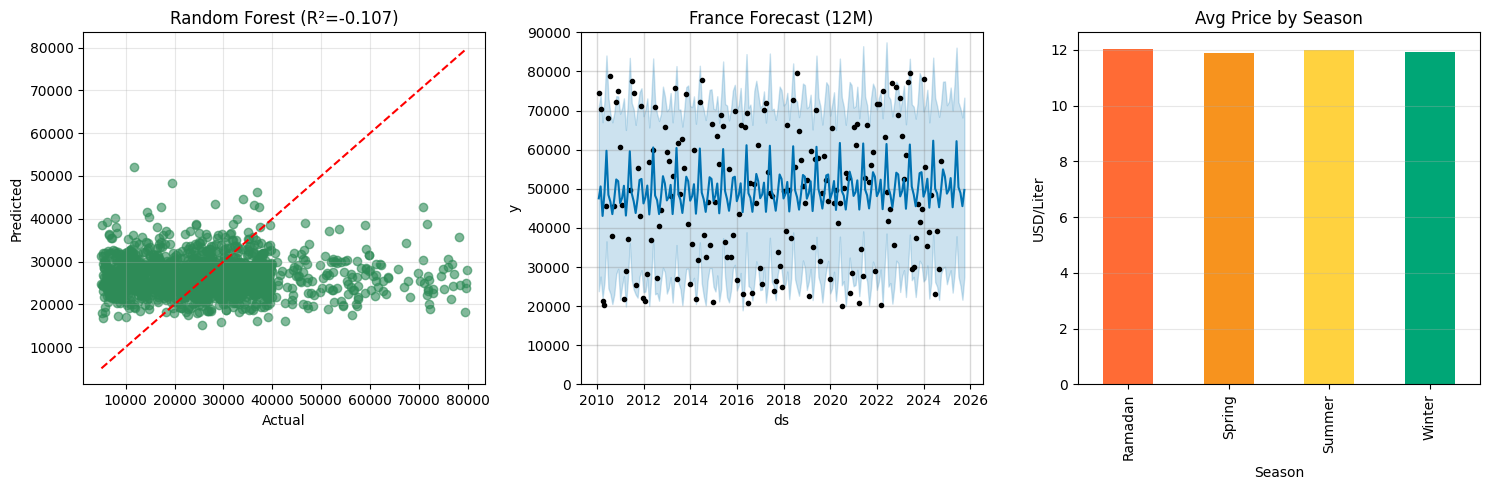

Saved: models/rf_model.pkl, models/prophet_model.pkl, reports/model_dashboard.png


In [5]:
# Dashboard with 3 subplots
plt.figure(figsize=(15, 5))

# 1) Random Forest: Actual vs Predicted
ax1 = plt.subplot(1, 3, 1)
ax1.scatter(y_test, y_pred, alpha=0.6, color='#2E8B57')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
ax1.plot(lims, lims, 'r--', linewidth=1.5)
ax1.set_title(f'Random Forest (R²={r2:.3f})')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.grid(alpha=0.3)

# 2) Prophet: France forecast (next 12 months)
ax2 = plt.subplot(1, 3, 2)
future = prophet.make_future_dataframe(periods=12, freq='M')
forecast = prophet.predict(future)
prophet.plot(forecast, ax=ax2)
ax2.set_title('France Forecast (12M)')
ax2.set_ylim(0, 90000)
ax2.grid(alpha=0.3)

# 3) Average price by season
ax3 = plt.subplot(1, 3, 3)
season_price = df.groupby('Season')['USD_Price'].mean()
season_price.plot(kind='bar', color=['#FF6B35', '#F7931E', '#FFD23F', '#00A676'], ax=ax3)
ax3.set_title('Avg Price by Season')
ax3.set_ylabel('USD/Liter')
ax3.grid(alpha=0.3, axis='y')

plt.tight_layout()
os.makedirs('../reports', exist_ok=True)
plt.savefig('../reports/model_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: models/rf_model.pkl, models/prophet_model.pkl, reports/model_dashboard.png")